In [ ]:
# import wandb
# !wandb login

In [366]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from tqdm.auto import tqdm
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from scipy.stats import qmc, norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

# sns.set(style='whitegrid', font_scale=1.2)
sns.reset_orig()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device), torch.__version__

cuda


(None, '2.0.0+cu118')

In [241]:
def black_scholes(S, K, T, r, sigma, option='call'):
    """
    Black-Scholes closed-form formula for European call and put options.
    
    Parameters:
        S (float): underlying asset price
        K (float): option strike price
        T (float): time to maturity in years
        r (float): risk-free interest rate
        sigma (float): volatility of the underlying asset
        option (str): 'call' for call option, 'put' for put option (default is 'call')
    
    Returns:
        float: option price according to the Black-Scholes formula
    """
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'")

In [269]:
data_description = '''
    msft_calls - list of pandas DataFrames, every item corresponds expiration 
                 expiration date from `expirations`. Each DF contains trading
                 info about call option
    
    msft_puts - same but for put options
    
    expirations - tuple of expirations dates in string format `YYYY-MM-DD`
'''

msft_calls = pd.read_pickle('data/msft_calls.pickle')
msft_puts = pd.read_pickle('data/msft_puts.pickle')
expirations = pd.read_pickle('data/expirations.pickle')

msft_stock_price = 294.3900146484375
day = '2022-03-16'

In [270]:
maturities = [
    (
        datetime.strptime(expiration, '%Y-%m-%d') - 
        (datetime.strptime(day, '%Y-%m-%d') if day else datetime.today())
    ).days / 256 
    for expiration in expirations
]

In [271]:
maturities = np.array(maturities)

df_lens = np.array([len(df) for df in msft_calls])
indxs = np.where((df_lens >= 40) & (df_lens <= 90))[0]

msft_calls = [msft_calls[i] for i in indxs]
expirations = [expirations[i] for i in indxs]
maturities = maturities[indxs]
len(msft_calls), len(expirations), len(maturities)

(12, 12, 12)

In [272]:
strikes = msft_calls[0].strike
for row in msft_calls:
  strikes = np.intersect1d(strikes, row.strike)
set_strikes = set(strikes)
print(len(strikes))

33


In [273]:
opt_prices = np.array([(df.bid + df.ask)[df.strike.isin(strikes)] / 2 for df in msft_calls])
opt_prices[np.isnan(opt_prices)] = 3.5e-2
opt_prices.shape

(12, 33)

In [274]:
vols = np.array([df.impliedVolatility.loc[df.strike.isin(strikes)] for df in msft_calls])
vols.shape

(12, 33)

In [275]:
def real_data_to_format(real_df, real_price, maturity, risk_free_rate):
    df = pd.DataFrame()
    df['S2K'] = real_price / real_df.strike
    df['T'] = maturity
    df['r'] = risk_free_rate
    df['sigma'] = real_df.impliedVolatility
    df['V2K'] = (real_df.bid + real_df.ask) / 2 / real_df.strike
    # df['time_value'] = df['V2K'] - np.maximum(0, df['S2K'] - np.exp(-df['r'] * df['T']))
    # df = df.loc[df.time_value > 1e-7].copy()
    # df['log_time_value'] = np.log(df['time_value'])
    # 0/0
    df = df.loc[(df.V2K > 1e-7) & (df.S2K > 1e-7)].copy()
    df['log_V2K'] = np.log(df['V2K'])
    df['log_S2K'] = np.log(df['S2K'])
    return df

In [276]:
idx = 2 
real_df_concated = pd.concat([
    real_data_to_format(msft_calls[idx], msft_stock_price, maturities[idx], 0.05) for idx in range(len(msft_calls))
])
display(real_df_concated.head())
real_df_concated.info()

,S2K,T,r,sigma,V2K,log_V2K,log_S2K
0,1.471950,0.035156,0.05,1.253422,0.467750,-0.759821,0.386588
1,1.338136,0.035156,0.05,1.038579,0.334659,-1.094643,0.291278
2,1.279957,0.035156,0.05,0.894044,0.276739,-1.284680,0.246826
3,1.252723,0.035156,0.05,0.781252,0.249043,-1.390132,0.225320
4,1.226625,0.035156,0.05,0.822756,0.224271,-1.494901,0.204267


<class 'pandas.core.frame.DataFrame'>
Int64Index: 764 entries, 0 to 67
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S2K      764 non-null    float64
 1   T        764 non-null    float64
 2   r        764 non-null    float64
 3   sigma    764 non-null    float64
 4   V2K      764 non-null    float64
 5   log_V2K  764 non-null    float64
 6   log_S2K  764 non-null    float64
dtypes: float64(7)
memory usage: 47.8 KB


In [277]:
real_df_concated.describe()

,S2K,T,r,sigma,V2K,log_V2K,log_S2K
count,764.000000,764.000000,7.640000e+02,764.000000,764.000000,764.000000,764.000000
mean,1.148224,0.933635,5.000000e-02,0.388918,0.283210,-3.099691,0.057728
std,0.515903,0.743466,4.860408e-17,0.209074,0.437543,2.673281,0.384623
min,0.566135,0.035156,5.000000e-02,0.000010,0.000010,-11.512925,-0.568923
25%,0.785040,0.363281,5.000000e-02,0.289916,0.008903,-4.721393,-0.242021
50%,0.997932,0.718750,5.000000e-02,0.333198,0.083980,-2.477183,-0.002070
75%,1.338136,1.429688,5.000000e-02,0.443067,0.386886,-0.949626,0.291278
max,3.679875,2.632812,5.000000e-02,3.716187,2.680313,0.985933,1.302879


### Parameters distributions

In [278]:
# for col in real_df_concated.columns:
#     plt.figure(figsize=(6,4))
#     plt.title(col)
#     plt.hist(real_df_concated[col], bins=25)
#     plt.show()

In [279]:
example_param_set = {
    'S' : 0.5,
    'K' : 1,
    'T' : 0.5,
    'r' : 0.05,
    'sigma' : 0.3 
}

black_scholes(**example_param_set)

3.2874437202908e-05

## Parameters sampling

In [280]:
%%time
# S2K, T, r, sigma -> V2K
# r may be constant
n_samples = 1_000_000
bounds_dict = {
    'S2K' : (0.4, 4),
    'T' : (0.01, 3),
    'r' : (0.025, 0.075),
    'sigma' : (0.001, 5)
}
l_bounds = [i[0] for k,i in bounds_dict.items()]
r_bounds = [i[1] for k,i in bounds_dict.items()]
lhc = qmc.LatinHypercube(d=4)
bs_params = qmc.scale(lhc.random(n=n_samples), l_bounds, r_bounds)
bs_params.shape

CPU times: total: 109 ms
Wall time: 149 ms


(1000000, 4)

In [78]:
distributions = pd.read_pickle('distributions.pkl')

def sample_distr(distr_info, size, non_neg=None):
    distr = distr_info[0]
    params = distr_info[1]
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    res = distr.rvs(size=size, *arg, loc=loc, scale=scale) if arg else distr.rvs(size=size, loc=loc, scale=scale)
    if non_neg is not None:
        res[res <= 0] = non_neg
    return res

In [125]:
# n_samples = 10_000_000
# bs_params = np.vstack([
#     sample_distr(distributions['S2K'], n_samples), 
#     # np.random.uniform(0.4, 2.0, n_samples),
#     np.random.uniform(0.01, 2, n_samples), # T
#     np.random.uniform(0.01, 0.1, n_samples), # r
#     sample_distr(distributions['sigma'], n_samples, non_neg=1e-4),
# ]).T
# bs_params.shape

(10000000, 4)

In [281]:
%%time
prices = black_scholes(bs_params[:,0], 1, bs_params[:,1], bs_params[:,2], bs_params[:,3])
prices.shape

CPU times: total: 62.5 ms
Wall time: 122 ms


(1000000,)

In [282]:
synt_df = pd.DataFrame(data=bs_params, columns=['S2K', 'T', 'r', 'sigma'])
synt_df['V2K'] = prices
display(df.head())
synt_df.info()

,S2K,T,r,sigma,V2K,log_V2K,log_S2K
0,2.573113,0.188156,0.086583,0.150497,1.589272,0.463276,0.945116
1,1.051987,1.540450,0.054776,0.885285,0.480473,-0.732985,0.050680
2,1.533263,1.396822,0.033081,0.547983,0.681441,-0.383546,0.427398
3,1.291036,1.057884,0.072468,0.489426,0.447524,-0.804026,0.255445
4,0.871046,1.437042,0.065100,0.986848,0.377589,-0.973949,-0.138061


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   S2K     1000000 non-null  float64
 1   T       1000000 non-null  float64
 2   r       1000000 non-null  float64
 3   sigma   1000000 non-null  float64
 4   V2K     1000000 non-null  float64
dtypes: float64(5)
memory usage: 38.1 MB


In [283]:
display(synt_df.describe())
display(real_df_concated.describe())

,S2K,T,r,sigma,V2K
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,2.200000,1.505000,0.050000,2.500500,1.836620
std,1.039231,0.863139,0.014434,1.443088,1.036882
min,0.400003,0.010002,0.025000,0.001001,0.000000
25%,1.300000,0.757500,0.037500,1.250750,0.951962
50%,2.199998,1.505000,0.050000,2.500501,1.809566
75%,3.099998,2.252500,0.062500,3.750250,2.685606
max,3.999998,2.999998,0.075000,4.999997,3.999382


,S2K,T,r,sigma,V2K,log_V2K,log_S2K
count,764.000000,764.000000,7.640000e+02,764.000000,764.000000,764.000000,764.000000
mean,1.148224,0.933635,5.000000e-02,0.388918,0.283210,-3.099691,0.057728
std,0.515903,0.743466,4.860408e-17,0.209074,0.437543,2.673281,0.384623
min,0.566135,0.035156,5.000000e-02,0.000010,0.000010,-11.512925,-0.568923
25%,0.785040,0.363281,5.000000e-02,0.289916,0.008903,-4.721393,-0.242021
50%,0.997932,0.718750,5.000000e-02,0.333198,0.083980,-2.477183,-0.002070
75%,1.338136,1.429688,5.000000e-02,0.443067,0.386886,-0.949626,0.291278
max,3.679875,2.632812,5.000000e-02,3.716187,2.680313,0.985933,1.302879


In [284]:
# df['time_value'] = df['V2K'] - np.maximum(0, df['S2K'] - np.exp(-df['r'] * df['T']))
# df = df.loc[df.time_value > 1e-7].copy()
# df['log_time_value'] = np.log(df['time_value'])
print('before', synt_df.shape)
synt_df = synt_df.loc[(synt_df.V2K > 1e-7) & (synt_df.S2K > 1e-7)].copy()
print('after', synt_df.shape)
synt_df['log_V2K'] = np.log(synt_df['V2K'])
synt_df['log_S2K'] = np.log(synt_df['S2K'])
synt_df.describe()

before (1000000, 5)
after (997300, 5)


,S2K,T,r,sigma,V2K,log_V2K,log_S2K
count,997300.000000,997300.000000,997300.000000,997300.000000,9.973000e+05,997300.000000,997300.000000
mean,2.204393,1.506487,0.050001,2.506961,1.841592e+00,0.320416,0.645428
std,1.037175,0.862704,0.014433,1.439659,1.033866e+00,1.083784,0.585013
min,0.400003,0.010003,0.025000,0.001001,1.002594e-07,-16.115505,-0.916284
25%,1.307291,0.759656,0.037503,1.260863,9.588743e-01,-0.041995,0.267957
50%,2.204861,1.506892,0.050002,2.507249,1.814266e+00,0.595681,0.790664
75%,3.102431,2.253608,0.062500,3.753623,2.688008e+00,0.988801,1.132186
max,3.999998,2.999998,0.075000,4.999997,3.999382e+00,1.386140,1.386294


In [285]:
class MyDataset(Dataset):
    def __init__(self, df, columns, target):
        self.df = df
        self.columns = columns
        self.target = target
        self.data_tensor = torch.Tensor(df[columns].values)
        self.target_tensor = torch.Tensor(df[target].values)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return (self.data_tensor[idx], self.target_tensor[idx])

In [287]:
class ANN(nn.Module):
    def __init__(self, struct, bn=False):
        super().__init__()
        layers = []
        for i,l in enumerate(struct[:-1]):
            if bn:
                layers.append(nn.BatchNorm1d(struct[i]))
            
            layers += [
                nn.Linear(struct[i], struct[i+1]),
                nn.ReLU()
            ]

        self.net = nn.Sequential(*layers[:-1])

    def forward(self, x):
        return self.net(x).sigmoid()

In [286]:
df_train, df_test = train_test_split(synt_df, train_size=0.8)

In [343]:
size = 1000
noise = np.vstack([
    np.random.normal(0, 5e-2, 764 * size),  # S2K
    np.random.normal(0, 1e-4, 764 * size),  # T
    np.random.normal(0, 1e-3, 764 * size),  # r
    np.random.normal(0, 5e-2, 764 * size),  # sigma
    np.zeros(764 * size), 
    np.random.normal(0, 5e-2, 764 * size),  # log_v2k
    np.zeros(764 * size), 
]).T
cheat_df = pd.concat([real_df_concated]*size) + noise
cheat_df.sigma.loc[cheat_df.sigma <= 0] = 1e-4
cheat_df.shape

(764000, 7)

In [344]:
display(cheat_df.describe())
print('Source')
real_df_concated.describe()

,S2K,T,r,sigma,V2K,log_V2K,log_S2K
count,764000.000000,764000.000000,764000.000000,7.640000e+05,764000.000000,764000.000000,764000.000000
mean,1.148210,0.933635,0.050002,3.894240e-01,0.283210,-3.099625,0.057728
std,0.517963,0.742980,0.001001,2.138534e-01,0.437257,2.672009,0.384372
min,0.333966,0.034739,0.045410,2.764704e-07,0.000010,-11.699788,-0.568923
25%,0.785973,0.363272,0.049326,2.854546e-01,0.008903,-4.732745,-0.242021
50%,0.994780,0.718727,0.050001,3.463178e-01,0.083980,-2.467367,-0.002070
75%,1.353188,1.429642,0.050678,4.491096e-01,0.386886,-0.951813,0.291278
max,3.847672,2.633208,0.054919,3.897260e+00,2.680313,1.147057,1.302879


Source


,S2K,T,r,sigma,V2K,log_V2K,log_S2K
count,764.000000,764.000000,7.640000e+02,764.000000,764.000000,764.000000,764.000000
mean,1.148224,0.933635,5.000000e-02,0.388918,0.283210,-3.099691,0.057728
std,0.515903,0.743466,4.860408e-17,0.209074,0.437543,2.673281,0.384623
min,0.566135,0.035156,5.000000e-02,0.000010,0.000010,-11.512925,-0.568923
25%,0.785040,0.363281,5.000000e-02,0.289916,0.008903,-4.721393,-0.242021
50%,0.997932,0.718750,5.000000e-02,0.333198,0.083980,-2.477183,-0.002070
75%,1.338136,1.429688,5.000000e-02,0.443067,0.386886,-0.949626,0.291278
max,3.679875,2.632812,5.000000e-02,3.716187,2.680313,0.985933,1.302879


In [345]:
cheat_df_train, cheat_df_test = train_test_split(cheat_df, train_size=0.8)

In [346]:
columns = [
    # 'log_time_value',
    'log_V2K',
    'r',
    'T',
    # 'log_S2K'
    'S2K'
]
target = 'sigma'
dataset_train = MyDataset(cheat_df_train, columns, target)
dataset_test = MyDataset(cheat_df_test, columns, target)
dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=10_000)
dataloader_test = DataLoader(dataset_test, shuffle=False, batch_size=10_000)

In [347]:
struct_ann = [4, 256, 512, 256, 64, 1]
model = ANN(struct_ann, bn=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [348]:
def train(model, optimizer, criterion, dataloader_train, dataloader_test, num_epochs, noise=None, writer=None):
    logs = {
        'train_loss' : [],
        'test_loss' : []
    }
    model.train()
    for epoch in tqdm(range(num_epochs), desc='Epoch'):
        running_loss = 0.0
        for iter_num, (X,y) in enumerate(dataloader_train):
            X = X.to(device)
            y = y.to(device).unsqueeze(1)
            if noise is not None:
                y = y + torch.rand_like(y) * noise
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

            if writer is not None:
                writer.add_scalars("loss_iter", {'train' : loss}, iter_num + epoch * len(dataloader_train))

        logs['train_loss'].append(running_loss/len(dataloader_train))

        running_loss = 0.0
        for iter_num, (X,y) in enumerate(dataloader_test):
            with torch.no_grad():
                X = X.to(device)
                y = y.to(device).unsqueeze(1)
                out = model(X)
                loss = criterion(out, y)
                running_loss += loss.item()
                if writer is not None:
                    writer.add_scalars('loss_iter', {'test' : loss}, iter_num + epoch * len(dataloader_test))

        logs['test_loss'].append(running_loss/len(dataloader_test))
        
        if writer is not None:
            writer.add_scalars('loss_epoch', {
                'train': logs['train_loss'][-1],
                'test': logs['test_loss'][-1],
            }, epoch)

    if writer is not None:
        writer.close()
        
    return logs

In [349]:
EXP_NAME = 'cheat_sigmoid_noise0'
logs = train(model, optimizer, criterion, 
             dataloader_train, dataloader_test, 
             num_epochs=100, noise=None,
             writer=SummaryWriter(f'logs/{EXP_NAME}'))

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

In [374]:
torch.save(model.state_dict(), f'models/{EXP_NAME}.pth')

## Тестим на реальных данных MSFT

In [350]:
idx = 3
real_df = real_data_to_format(msft_calls[idx], msft_stock_price, maturities[idx], 0.05)

In [351]:
columns = [
    # 'log_time_value',
    'log_V2K',
    'r',
    'T',
    # 'log_S2K'
    'S2K'
]
target = 'sigma'
real_dataset = MyDataset(real_df, columns, target)
real_dataloader = DataLoader(real_dataset, shuffle=False, batch_size=len(real_dataset))

In [375]:
load_model = ANN(struct_ann, bn=True).to(device)
load_model.load_state_dict(torch.load('models/cheat_sigmoid_noise0.pth'))

<All keys matched successfully>

In [352]:
model.eval()
with torch.no_grad():
    X, y = next(iter(real_dataloader))
    X = X.to(device)
    y = y.unsqueeze(1)
    out = model(X).cpu()
    loss = criterion(out, y)
    print(f'Loss: {loss.item():0.4f}')

Loss: 0.0951


In [353]:
print(f'Train loss: {logs["train_loss"][-1]:0.4f}')
print(f'Test loss: {logs["test_loss"][-1]:0.4f}')

Train loss: 0.0175
Test loss: 0.0183


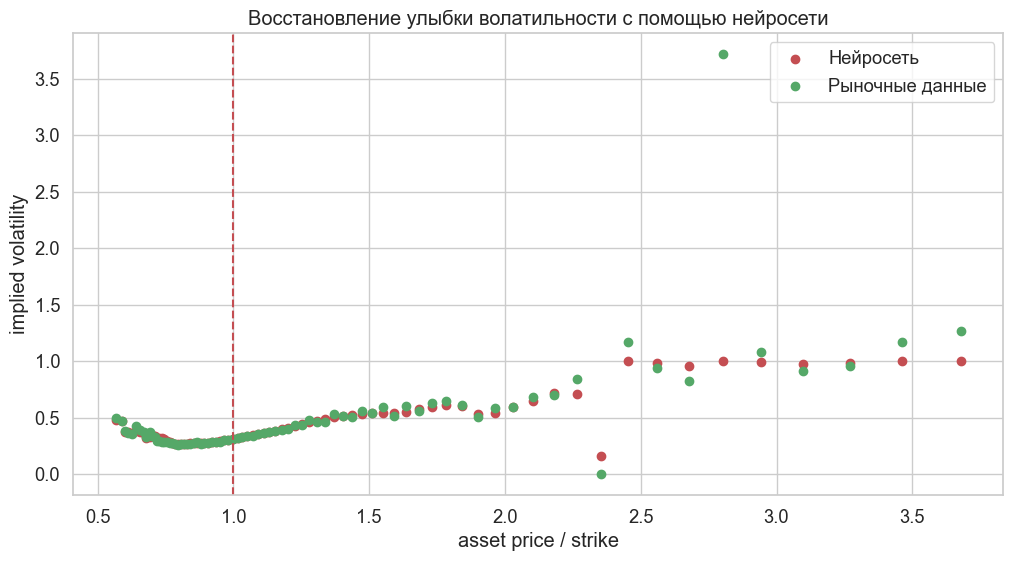

In [356]:
plt.figure(figsize=(12,6))
plt.title('Восстановление улыбки волатильности с помощью нейросети')
plt.scatter(y=out[:,0], x=real_df.S2K, c='r', label='Нейросеть')
plt.scatter(x=real_df.S2K, y=real_df.sigma, c='g', label='Рыночные данные')
plt.axvline(x=1, c='r', linestyle='--')
plt.xlabel('asset price / strike')
plt.ylabel('implied volatility')
plt.legend()
plt.show()

Надо расширить границы семплинга параметров, чтобы нейросеть могла обучиться более подробно   
Так же стоит добавить шум при обучении, чтобы сетка была более стабильна

# Поверхность волатильности

In [376]:
%%time
load_model.eval()
surface = np.zeros((len(maturities), len(strikes)), dtype=float)

for i, t in enumerate(zip(maturities)):
    cur_batch = torch.tensor(np.vstack([
        np.log(opt_prices[i] / strikes),
        np.repeat(0.05, len(strikes)),
        np.repeat(t, len(strikes)),
        msft_stock_price / strikes
    ]), dtype=torch.float32).T.to(device)
    
    with torch.no_grad():
        surface[i,:] = load_model(cur_batch).cpu().numpy().squeeze(1)

CPU times: total: 0 ns
Wall time: 21.9 ms


In [377]:
MSE(vols, surface)

0.0004537852610286822

In [378]:
surface_correct = surface.copy()
surface_correct[surface_correct > 10] = 0.8
surface_correct[surface_correct <= 0] = 1e-4
surface_correct[4,0] = 0.45

MSE(vols, surface_correct)

0.0003178072022325744

In [300]:
def plot_surface(X,Y,Z, title):
    X, Y = np.meshgrid(X, Y)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15,6))
    ax.set_title(title)

    surf = ax.plot_surface(X, Y, Z, 
                        cmap=cm.coolwarm,
                        linewidth=0.1,
                        edgecolor='white')

    fig.colorbar(surf, shrink=0.3, aspect=10)
    ax.set_zlabel('Implied volatility')
    ax.set_xlabel('Strike, $')
    ax.set_ylabel('Maturity, years')
    plt.show()

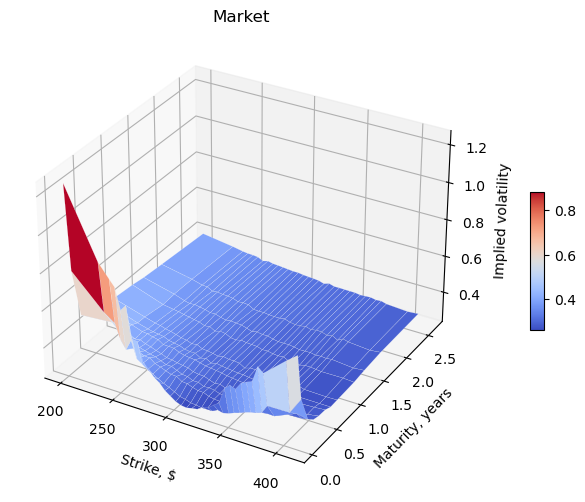

In [368]:
plot_surface(strikes, maturities, vols, 'Market')

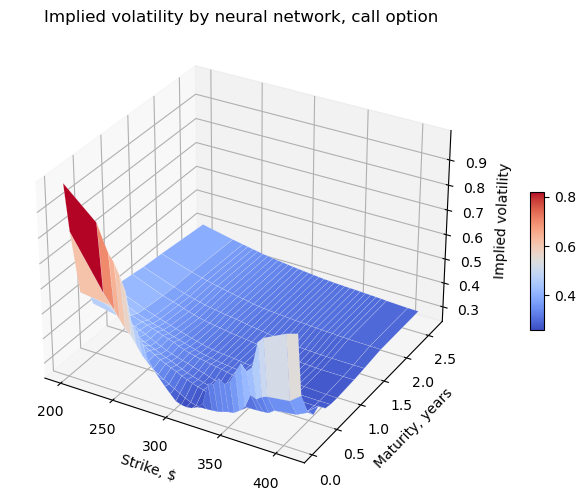

In [371]:
plot_surface(strikes, maturities, surface_correct, title='Implied volatility by neural network, call option')

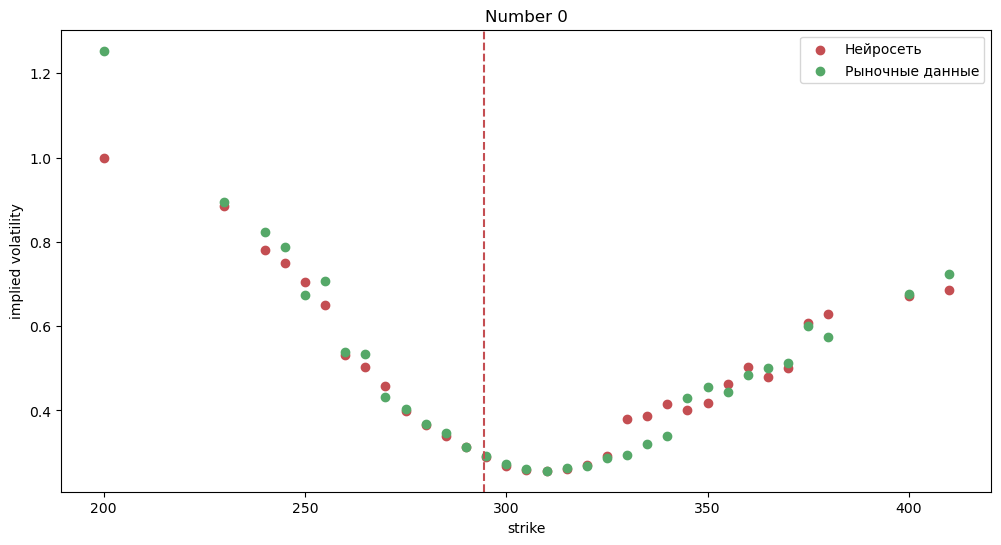

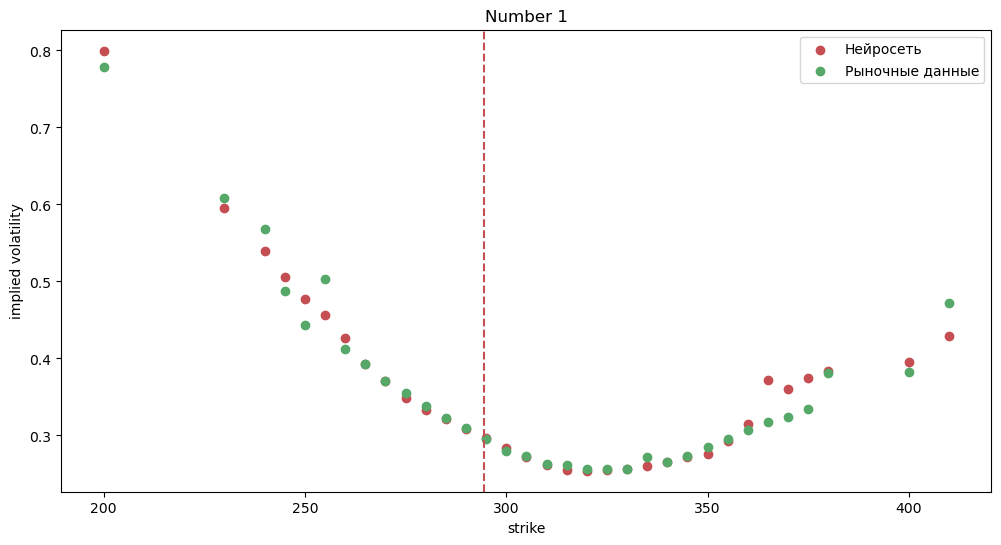

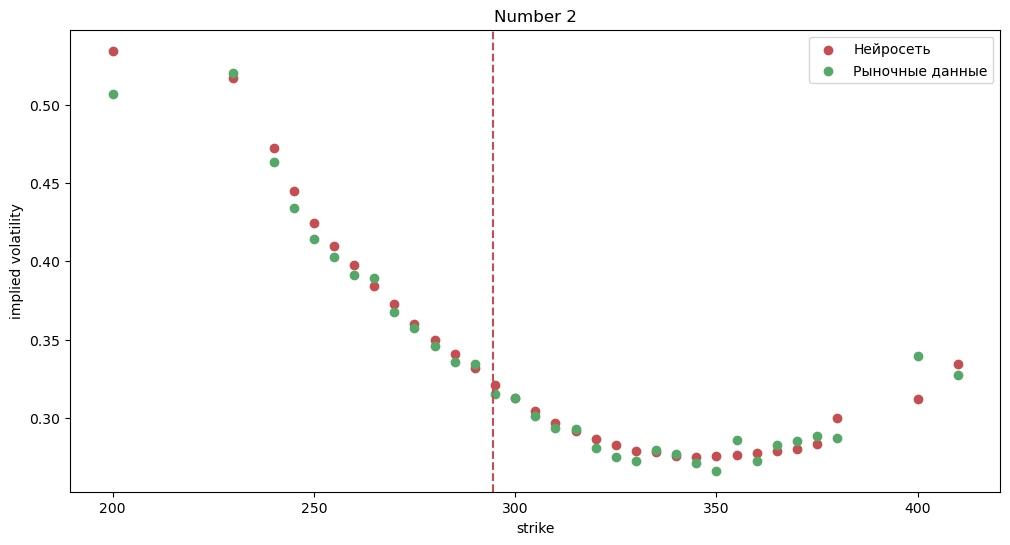

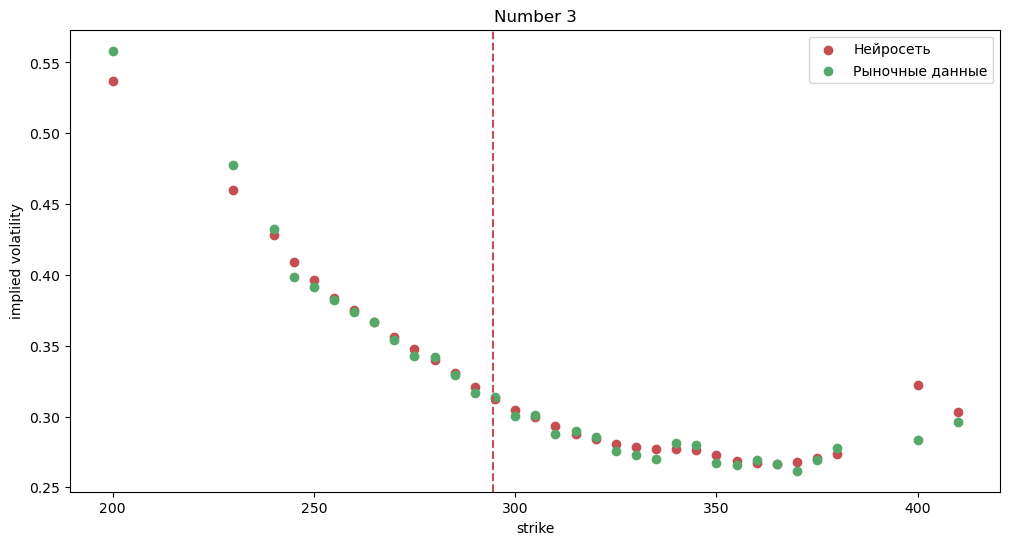

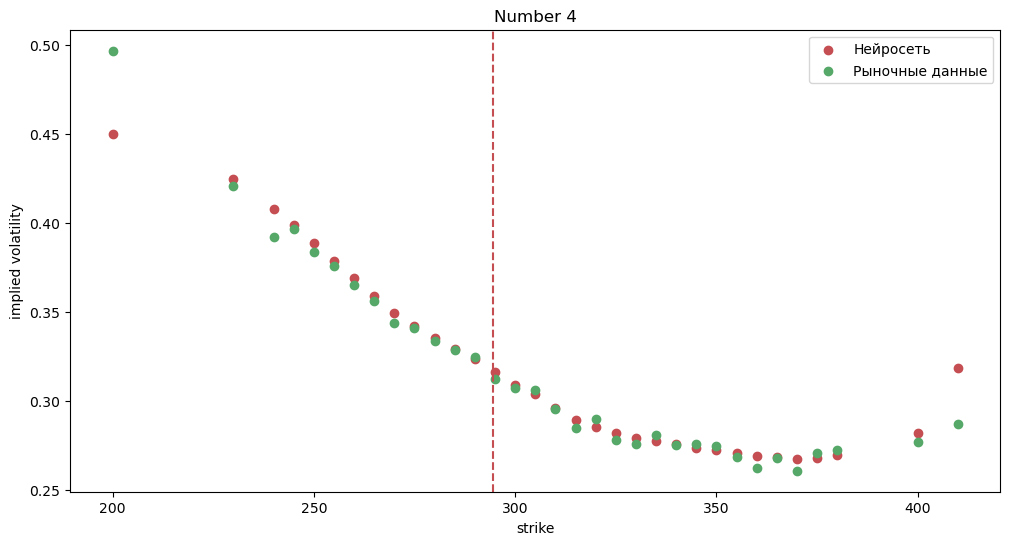

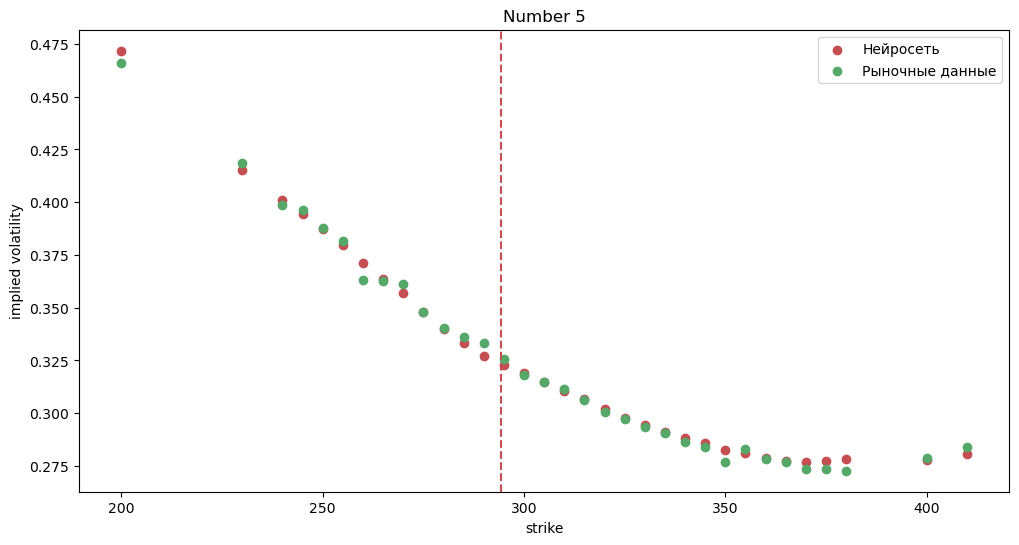

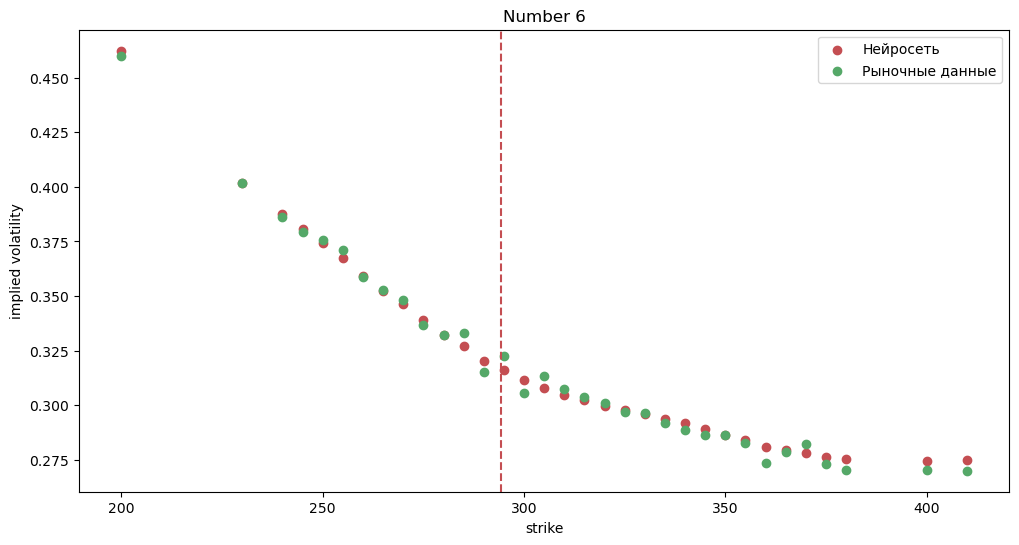

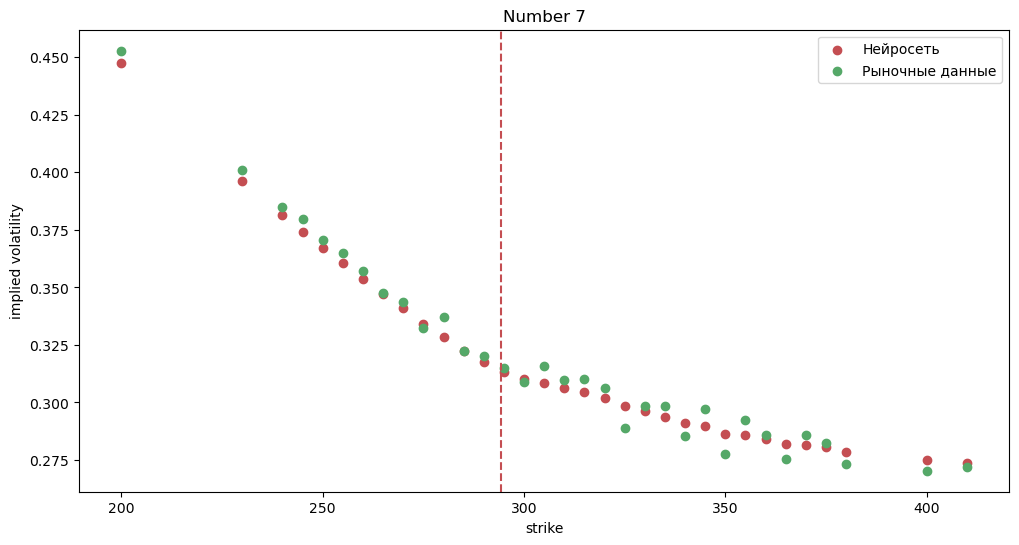

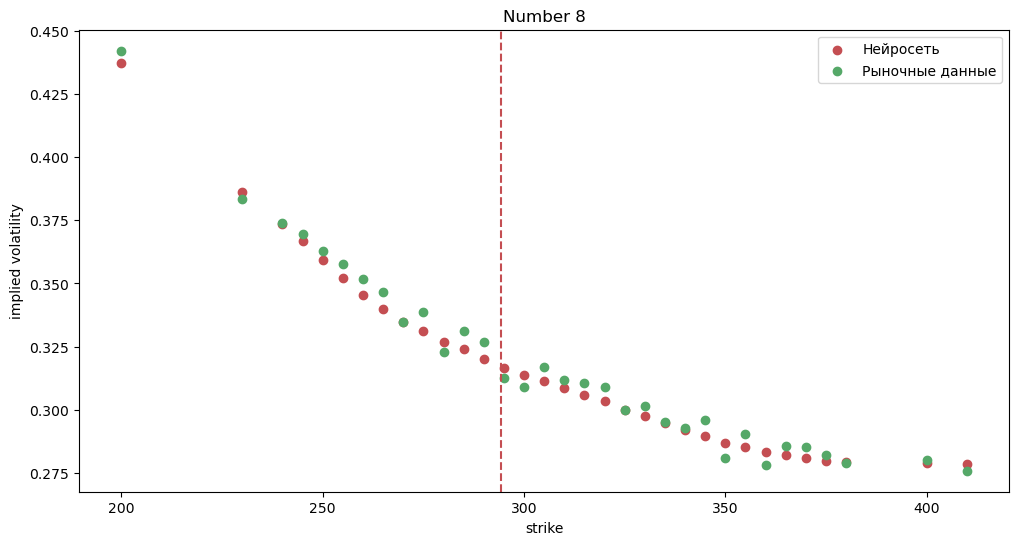

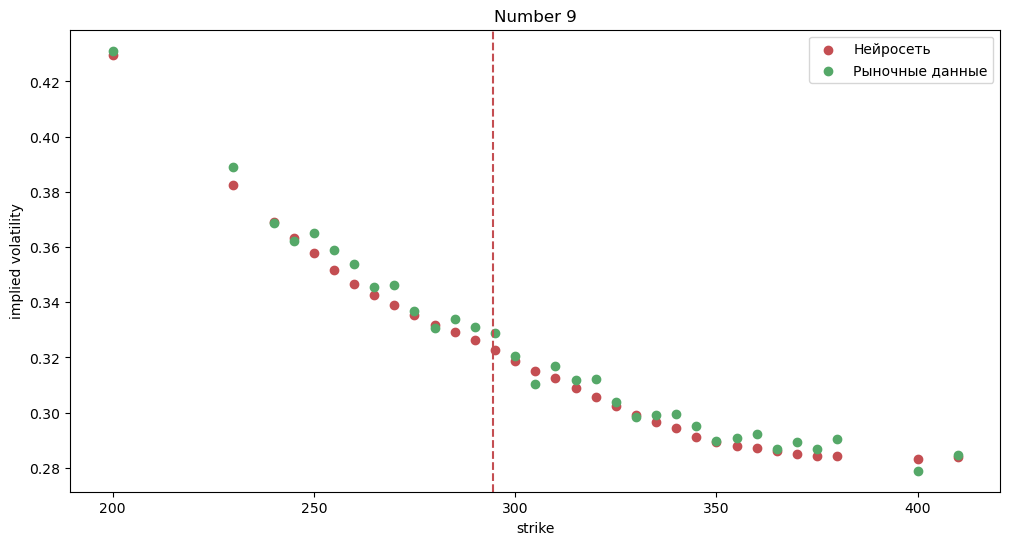

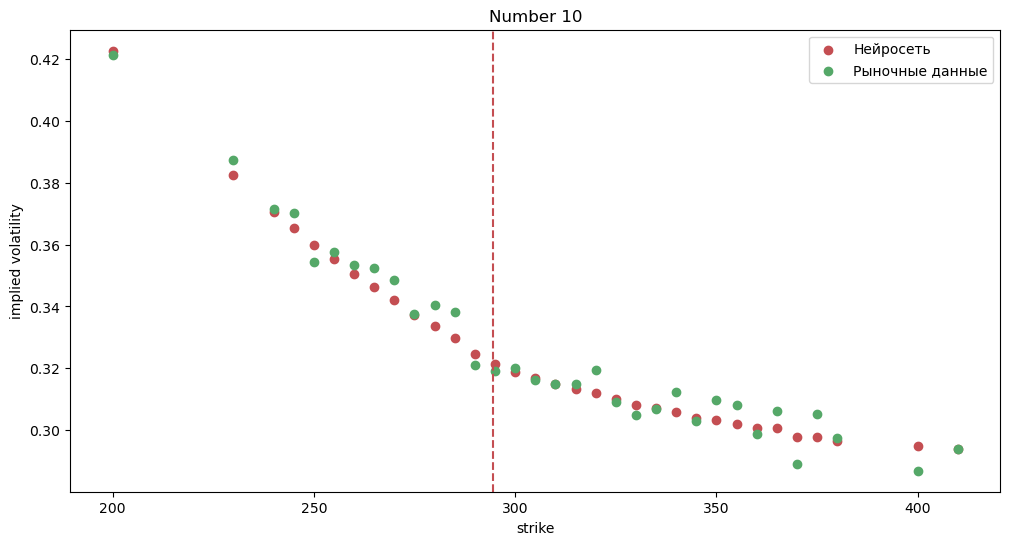

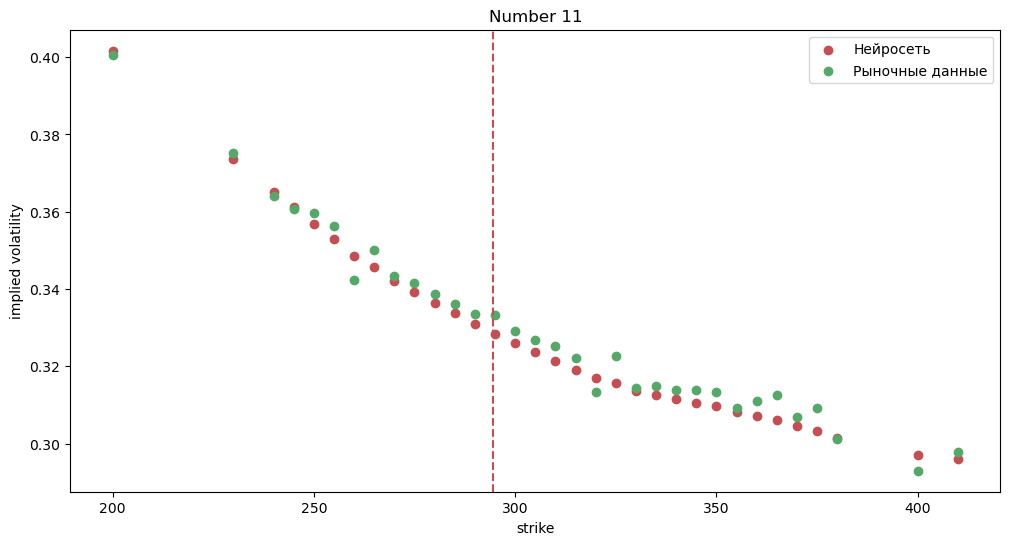

In [372]:
for i in range(len(maturities)):
    plt.figure(figsize=(12,6))
    # plt.title('Восстановление улыбки волатильности с помощью нейросети')
    plt.title(f'Number {i}')
    plt.scatter(x=strikes, y=surface_correct[i], c='r', label='Нейросеть')
    plt.scatter(x=strikes, y=vols[i], c='g', label='Рыночные данные')
    plt.axvline(x=msft_stock_price, c='r', linestyle='--')
    plt.xlabel('strike')
    plt.ylabel('implied volatility')
    plt.legend()
    plt.show()

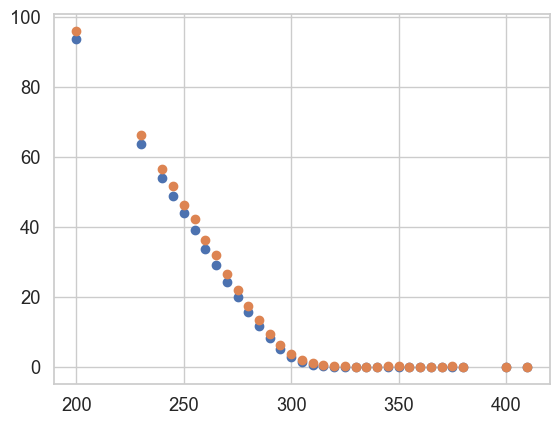

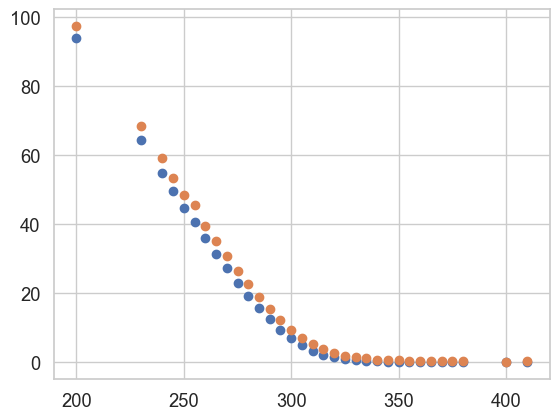

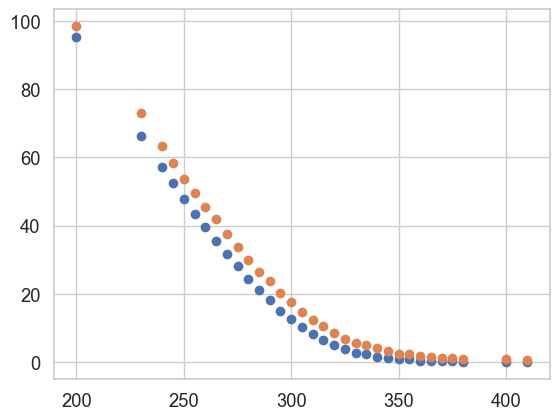

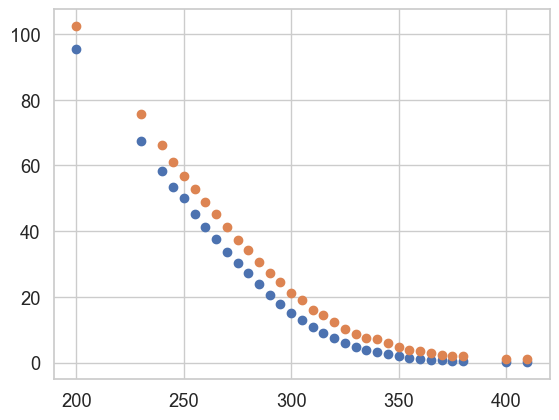

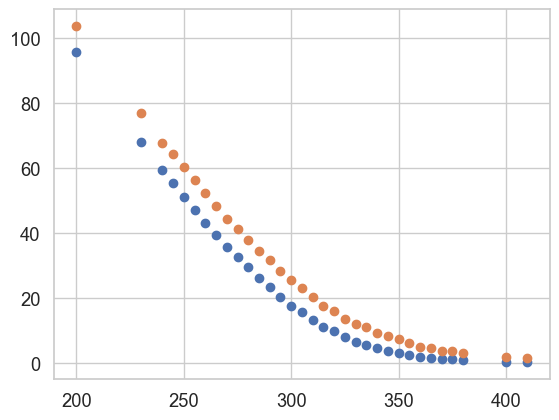

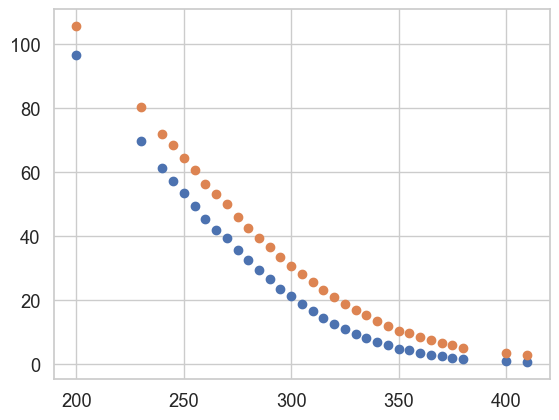

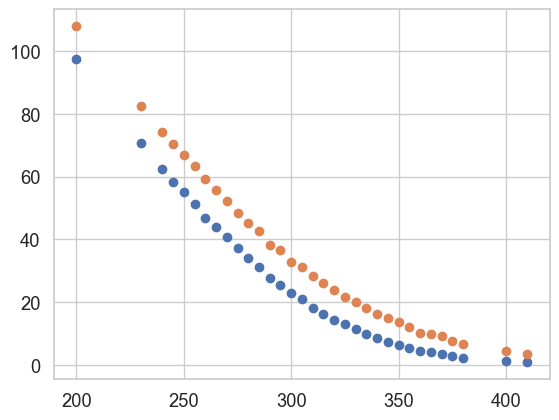

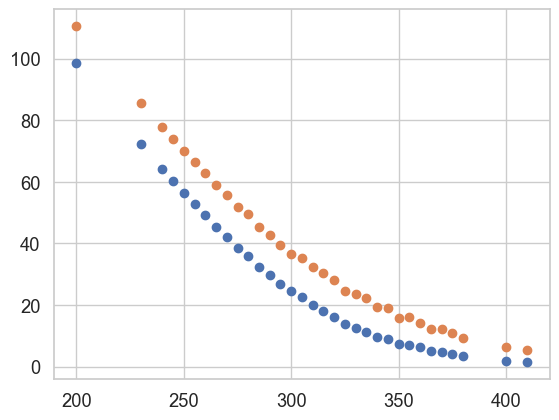

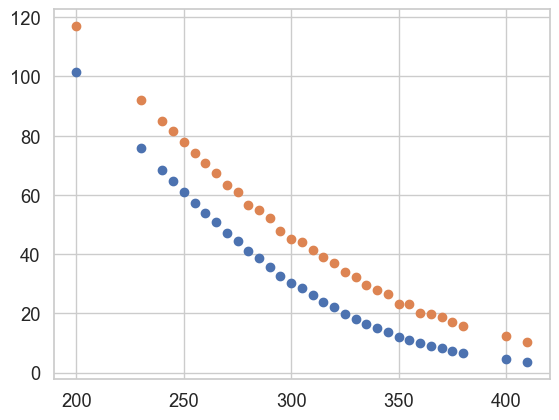

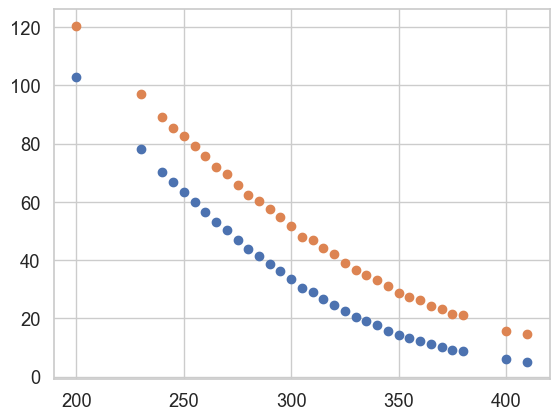

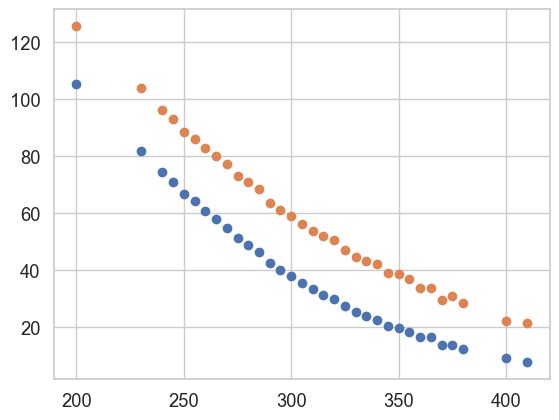

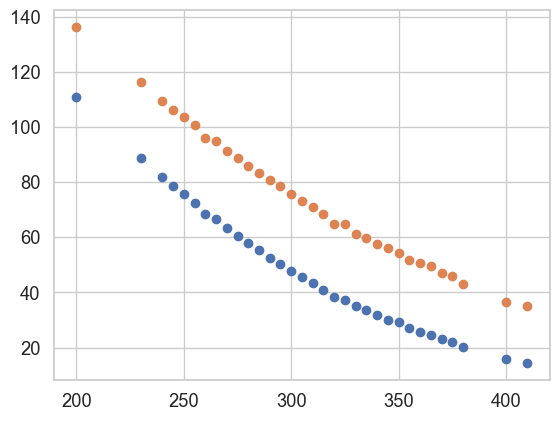

In [308]:
bs_prices = black_scholes(msft_stock_price, strikes[:,None], maturities, 0.05, vols.T).T

for i in range(len(maturities)):
    plt.scatter(strikes, opt_prices[i], label='market')
    plt.scatter(strikes, bs_prices[i], label='BS')
    plt.show()